In [80]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d

In [81]:
def gen_data(n, verbose=True):
    # Generate class A
    mA = np.array([1.0, 0.3])
    sigmaA = 0.2
    mB = np.array([0.0, -0.1])
    sigmaB = 0.3
    
    # Initialize class A with bias term
    classA = np.ones((n, 2))
    half_n = round(0.5 * n)
    
    # Generate split distribution for class A
    classA[:half_n, 0] = np.random.randn(half_n) * sigmaA - mA[0]  # Left cluster
    classA[half_n:, 0] = np.random.randn(n - half_n) * sigmaA + mA[0]  # Right cluster
    classA[:, 1] = np.random.randn(n) * sigmaA + mA[1]  # Second coordinate
    
    # Generate class B
    classB = np.ones((n, 2))
    classB[:, 0] = np.random.randn(n) * sigmaB + mB[0]
    classB[:, 1] = np.random.randn(n) * sigmaB + mB[1]

    lenA = len(classA)
    lenB = len(classB)

    if verbose:
        # Plot the data
        plt.figure(figsize=(10, 7))
        plt.scatter(classA[:, 0], classA[:, 1], label='Class A')
        plt.scatter(classB[:, 0], classB[:, 1], label='Class B')
        plt.xlabel('x₁')
        plt.ylabel('x₂')
        plt.title(f'Original Non-linearly Separable Data')
        plt.legend()
        plt.grid(True)
        plt.show()

    return classA, classB, lenA, lenB

In [82]:
def split_data(classA, classB, scenario='random_25'):
    """Split data according to scenarios with proper validation"""
    nA = len(classA)
    nB = len(classB)
    
    if scenario == 'random_25':
        # Remove 25% for training from each class
        trainA = int(0.75 * nA)
        trainB = int(0.75 * nB)
        
        # Random permutation indices
        idxA = np.random.permutation(nA)
        idxB = np.random.permutation(nB)
        
        # Split indices
        trainA_idx = idxA[:trainA]
        trainB_idx = idxB[:trainB]
        valA_idx = idxA[trainA:]
        valB_idx = idxB[trainB:]
        
        # Create training and validation sets
        trainA = classA[trainA_idx]
        trainB = classB[trainB_idx]
        valA = classA[valA_idx]
        valB = classB[valB_idx]
        
    elif scenario == 'classA_50':
        trainA = int(0.5 * nA)
        idxA = np.random.permutation(nA)
        trainA_idx = idxA[:trainA]
        valA_idx = idxA[trainA:]
        
        # Create sets
        trainA = classA[trainA_idx]
        trainB = classB  # All of class B for training
        valA = classA[valA_idx]
        valB = np.zeros((0, classB.shape[1]))  # Empty array with correct dims
        
    elif scenario == 'classA_split':
        # Find left/right split points for classA
        left_idx = np.where(classA[:, 0] < 0)[0]
        right_idx = np.where(classA[:, 0] >= 0)[0]
        
        # Take 80% from left and 20% from right
        trainA_left = int(0.8 * len(left_idx))
        trainA_right = int(0.2 * len(right_idx))
        
        np.random.shuffle(left_idx)
        np.random.shuffle(right_idx)
        
        trainA_idx = np.concatenate([
            left_idx[:trainA_left],
            right_idx[:trainA_right]
        ])
        valA_idx = np.concatenate([
            left_idx[trainA_left:],
            right_idx[trainA_right:]
        ])
        
        # Create sets
        trainA = classA[trainA_idx]
        trainB = classB  # All of class B for training
        valA = classA[valA_idx]
        valB = np.zeros((0, classB.shape[1]))  # Empty array with correct dims
    
    # If no scenario is specified, return all data
    else:
        trainA = classA
        trainB = classB
        valA = np.zeros((0, classA.shape[1]))  # Empty array with correct dims
        valB = np.zeros((0, classB.shape[1]))  # Empty array with correct dims
        
    
    return trainA, trainB, valA, valB

In [83]:
def prepare_data(classA, classB):
    """Prepare data handling empty arrays"""
    # Convert empty arrays to None
    classA = None if isinstance(classA, np.ndarray) and len(classA) == 0 else classA
    classB = None if isinstance(classB, np.ndarray) and len(classB) == 0 else classB
    
    # Get lengths of classes
    if classA is None:
        len_A = 0
        len_B = len(classB)
        X = classB
    elif classB is None:
        len_B = 0
        len_A = len(classA)
        X = classA
    else:
        len_A = len(classA)
        len_B = len(classB)
        X = np.vstack((classA, classB))

    # Set targets: +1 for Class A, -1 for Class B
    T = np.hstack((np.ones(len_A), -np.ones(len_B)))

    # Random permutation - but keep track of original class assignments
    perm = np.random.permutation(len(X))
    X, T = X[perm], T[perm]
    
    # Create a mask to track which predictions belong to which class
    class_mask = np.hstack((np.ones(len_A), np.zeros(len_B)))[perm]

    return X.T, T, class_mask, len_A, len_B

In [84]:
def sigmoid(x):
    return 2 / (1 + np.exp(-x)) - 1

In [85]:
def delta_sigmoid(x):
    return (1 + sigmoid(x)) * (1 - sigmoid(x)) * 0.5

In [86]:
def forward_pass(X, W, V):
    # Add bias to input
    X_bias = np.vstack((X, np.ones((1, X.shape[1]))))
    
    # Hidden layer
    WX = np.dot(W, X_bias)
    H = sigmoid(WX)
    
    # Add bias to hidden layer
    H_bias = np.vstack((H, np.ones((1, H.shape[1]))))
    
    # Output layer
    VH = np.dot(V, H_bias)
    O = sigmoid(VH)
    
    return X_bias, H, H_bias, O


In [87]:
def backward_pass(X_bias, H_bias, O, V, T):
    # Output layer error
    delta_o = (O - T) * delta_sigmoid(O)
    
    # Hidden layer error (before removing bias)
    delta_h = np.dot(V.T, delta_o) * delta_sigmoid(H_bias)
    
    # Remove bias term from hidden layer error
    delta_h = delta_h[:-1, :]  # Remove last row which corresponds to bias
    
    return delta_o, delta_h

In [88]:
def train_batch(X, T, Nhidden, epochs=20, lr=0.01, momentum=0.9):
    input_dim = X.shape[0]
    output_dim = 1

    # Initialize weights
    W = np.random.randn(Nhidden, input_dim + 1) * 0.1  # +1 for bias
    V = np.random.randn(output_dim, Nhidden + 1) * 0.1  # +1 for bias

    print(f'Shape of W: {W.shape}')
    print(f'Shape of V: {V.shape}')
    
    # Initialize momentum terms
    dW = np.zeros_like(W)
    dV = np.zeros_like(V)
    
    errors = []

    for epoch in range(epochs):
        # Forward pass
        X_bias, H, H_bias, O = forward_pass(X, W, V)

        # Backward pass
        delta_o, delta_h = backward_pass(X_bias, H_bias, O, V, T)

        # Update weights with momentum
        # For hidden layer weights (W)
        dW = momentum * dW - (1 - momentum) * lr * np.dot(delta_h, X_bias.T)
        W += dW
        
        # For output layer weights (V)
        dV = momentum * dV - (1 - momentum) * lr * np.dot(delta_o, H_bias.T)
        V += dV

        # Calculate error
        error = np.mean((O - T) ** 2)
        errors.append(error)
    
    return [W, V], errors

In [89]:
def train_sequential(X, T, Nhidden, epochs=20, lr=0.01, momentum=0.9):
    """
    Train network using sequential (online) learning
    X: input patterns (input_dim, n_patterns)
    T: targets (n_patterns,) - will be reshaped as needed
    """
    input_dim = X.shape[0]
    output_dim = 1
    n_patterns = X.shape[1]

    # Initialize weights
    W = np.random.randn(Nhidden, input_dim + 1) * 0.1  # +1 for bias
    V = np.random.randn(output_dim, Nhidden + 1) * 0.1  # +1 for bias
    
    # Initialize momentum terms
    dW = np.zeros_like(W)
    dV = np.zeros_like(V)
    
    errors = []

    for epoch in range(epochs):
        epoch_error = 0
        
        # Create random permutation for sequential pattern presentation
        pattern_order = np.random.permutation(n_patterns)
        
        # Process each pattern sequentially
        for i in pattern_order:
            # Get single pattern and its target
            pattern = X[:, i:i+1]  # Keep 2D shape (input_dim, 1)
            target = np.array([[T[i]]])  # Reshape to (1,1) for single target
            
            # Forward pass
            X_bias, H, H_bias, O = forward_pass(pattern, W, V)
            
            # Backward pass
            delta_o, delta_h = backward_pass(X_bias, H_bias, O, V, target)
            
            # Update weights with momentum for this pattern
            dW = momentum * dW - (1 - momentum) * lr * np.dot(delta_h, X_bias.T)
            W += dW
            
            dV = momentum * dV - (1 - momentum) * lr * np.dot(delta_o, H_bias.T)
            V += dV
            
            # Accumulate error for this pattern
            epoch_error += np.mean((O - target) ** 2)
        
        # Store average error for epoch
        errors.append(epoch_error / n_patterns)
    
    return [W, V], errors

In [90]:
def predict(X, W):
    """Predict output for given input using trained weights"""
    W_hidden, W_output = W  # Unpack weights
    
    # Forward pass to get prediction
    _, _, _, O = forward_pass(X, W_hidden, W_output)
    
    return O

In [91]:
def eval_data(T_pred, class_mask, lenA, lenB):
    """
    Evaluate model predictions against correct labels using class mask
    """
    # Flatten predictions if they're 2D
    T_pred = T_pred.flatten()
    
    # Use mask to separate predictions by original class
    classA_pred = T_pred[class_mask == 1]
    classB_pred = T_pred[class_mask == 0]
    
    classA_acc = np.mean(classA_pred > 0)
    classB_acc = np.mean(classB_pred < 0)

    return {'classA_acc': classA_acc, 'classB_acc': classB_acc}

In [92]:
def plot_decision_boundaries(X, W_batch, W_seq, trainA, trainB, valA, valB):
    """
    Plot decision boundaries for both batch and sequential learning
    """
    # Create a grid of points
    x_min = min(np.min(trainA[:, 0]), np.min(trainB[:, 0])) - 0.5
    x_max = max(np.max(trainA[:, 0]), np.max(trainB[:, 0])) + 0.5
    y_min = min(np.min(trainA[:, 1]), np.min(trainB[:, 1])) - 0.5
    y_max = max(np.max(trainA[:, 1]), np.max(trainB[:, 1])) + 0.5
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))
    
    # Make predictions using both models
    grid = np.c_[xx.ravel(), yy.ravel()].T
    Z_batch = predict(grid, W_batch).reshape(xx.shape)
    Z_seq = predict(grid, W_seq).reshape(xx.shape)
    
    # Plot decision boundaries and store the contour objects
    batch_contour = plt.contour(xx, yy, Z_batch, levels=[0], colors='b', linestyles='-')
    seq_contour = plt.contour(xx, yy, Z_seq, levels=[0], colors='r', linestyles='--')
    
    # Create proxy artists for the contours
    batch_proxy = plt.Line2D([0], [0], color='b', linestyle='-', label='Batch Boundary')
    seq_proxy = plt.Line2D([0], [0], color='r', linestyle='--', label='Sequential Boundary')
    
    # Plot training points
    plt.scatter(trainA[:, 0], trainA[:, 1], c='blue', alpha=0.5, 
               label='Class A (Train)')
    plt.scatter(trainB[:, 0], trainB[:, 1], c='red', alpha=0.5, 
               label='Class B (Train)')
    
    # Plot validation points if any
    if len(valA) > 0:
        plt.scatter(valA[:, 0], valA[:, 1], c='cyan', alpha=0.5, 
                   label='Class A (Val)')
    if len(valB) > 0:
        plt.scatter(valB[:, 0], valB[:, 1], c='pink', alpha=0.5, 
                   label='Class B (Val)')
    
    plt.xlabel('x₁')
    plt.ylabel('x₂')
    plt.title('Decision Boundaries')
    
    # Get current handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # Add the contour proxies to the handles
    handles = [batch_proxy, seq_proxy] + handles
    
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

In [ ]:
classA, classB, _, _ = gen_data(100)

X, T, class_mask, len_A, len_B = prepare_data(classA, classB)

print(f'Shape X: {X.shape}')
print(f'Shape T: {T.shape}')

In [ ]:
Nhidden = [5, 10, 20, 50]
error_list = []
evals_list = []

# Store both batch and sequential weights
W_batch_list = []
W_seq_list = []

for n in Nhidden:
    # Train both batch and sequential models
    W_batch, errors_batch = train_batch(X, T, n, epochs=3000, lr=0.01, momentum=0.9)
    W_seq, errors_seq = train_sequential(X, T, n, epochs=3000, lr=0.01, momentum=0.9)
    
    # Store weights
    W_batch_list.append(W_batch)
    W_seq_list.append(W_seq)
    
    # Get predictions for both models
    pred_batch = predict(X, W_batch)
    pred_seq = predict(X, W_seq)
    
    # Evaluate both models
    eval_batch = eval_data(pred_batch, class_mask, len_A, len_B)
    eval_seq = eval_data(pred_seq, class_mask, len_A, len_B)
    
    error_list.append({'batch': errors_batch, 'seq': errors_seq})
    evals_list.append({'batch': eval_batch, 'seq': eval_seq})

# Plot accuracies as bar plot
plt.figure(figsize=(12, 7))
x = np.arange(len(Nhidden))
width = 0.2  # Narrower bars to fit 4 categories

# Extract accuracies for both methods
batch_classA_acc = [evals['batch']['classA_acc'] for evals in evals_list]
batch_classB_acc = [evals['batch']['classB_acc'] for evals in evals_list]
seq_classA_acc = [evals['seq']['classA_acc'] for evals in evals_list]
seq_classB_acc = [evals['seq']['classB_acc'] for evals in evals_list]

# Create bar plot with all categories
plt.bar(x - 1.5*width, batch_classA_acc, width, label='Batch - Class A')
plt.bar(x - 0.5*width, batch_classB_acc, width, label='Batch - Class B')
plt.bar(x + 0.5*width, seq_classA_acc, width, label='Sequential - Class A')
plt.bar(x + 1.5*width, seq_classB_acc, width, label='Sequential - Class B')

plt.xlabel('Number of Hidden Units')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Batch vs Sequential Learning')
plt.xticks(x, Nhidden)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot training errors
plt.figure(figsize=(10, 7))
for i, n in enumerate(Nhidden):
    plt.plot(error_list[i]['batch'], label=f'Batch - {n} hidden units')
    plt.plot(error_list[i]['seq'], '--', label=f'Sequential - {n} hidden units')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Training Error Comparison')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Log scale to better see differences
plt.show()

# Plot decision boundaries for the best performing model
best_idx = np.argmax([np.mean([evals['batch']['classA_acc'], evals['batch']['classB_acc']]) 
                      for evals in evals_list])
plot_decision_boundaries(X, W_batch_list[best_idx], W_seq_list[best_idx], 
                        classA, classB, np.zeros((0, 2)), np.zeros((0, 2)))

In [78]:
def run_learning_comparison(classA, classB, network_sizes=[2, 5, 10, 50, 100], 
                          scenario='random_25', epochs=6000):
    """
    Compare batch vs sequential learning for different network architectures
    """
    # Split data according to scenario
    trainA, trainB, valA, valB = split_data(classA, classB, scenario)
    
    # Prepare training data
    X_train, T_train, mask_train, lenA_train, lenB_train = prepare_data(trainA, trainB)
    
    # Prepare validation data if we have any
    has_validation = len(valA) > 0 or len(valB) > 0
    if has_validation:
        X_val, T_val, mask_val, lenA_val, lenB_val = prepare_data(valA, valB)
    
    # Results storage
    results = []
    
    for n in network_sizes:
        print(f"\nTraining with {n} hidden nodes:")
        
        # Batch learning
        W_batch, errors_batch = train_batch(X_train, T_train, n, epochs=epochs, 
                                            lr=0.01, momentum=0.9)
        pred_batch = predict(X_train, W_batch)
        batch_eval = eval_data(pred_batch, mask_train, lenA_train, lenB_train)
        
        # Sequential learning
        W_seq, errors_seq = train_sequential(X_train, T_train, n, epochs=epochs, 
                                           lr=0.01, momentum=0.9)
        pred_seq = predict(X_train, W_seq)
        seq_eval = eval_data(pred_seq, mask_train, lenA_train, lenB_train)
        
        # Validation performance if available
        if has_validation:
            val_pred_batch = predict(X_val, W_batch)
            val_pred_seq = predict(X_val, W_seq)
            val_batch_eval = eval_data(val_pred_batch, mask_val, lenA_val, lenB_val)
            val_seq_eval = eval_data(val_pred_seq, mask_val, lenA_val, lenB_val)
        else:
            val_batch_eval = val_seq_eval = None
        
        results.append({
            'hidden_size': n,
            'batch': {
                'errors': errors_batch,
                'train_eval': batch_eval,
                'val_eval': val_batch_eval
            },
            'sequential': {
                'errors': errors_seq,
                'train_eval': seq_eval,
                'val_eval': val_seq_eval
            }
        })
        
        # Plot learning curves
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(errors_batch, label='Batch')
        plt.plot(errors_seq, label='Sequential')
        plt.xlabel('Epoch')
        plt.ylabel('MSE')
        plt.title(f'Learning Curves ({n} hidden nodes)')
        plt.yscale('log')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plot_decision_boundaries(X_train, W_batch, W_seq, trainA, trainB, 
                               valA, valB)
        
        plt.tight_layout()
        plt.show()
    
    return results

In [ ]:
# Generate data
classA, classB, _, _ = gen_data(100)

# Run comparison for different scenarios
scenarios = [None, 'random_25', 'classA_50', 'classA_split']
network_sizes = [2, 5, 10] #, 50, 100]

for scenario in scenarios:
    print(f"\nTesting scenario: {scenario}")
    results = run_learning_comparison(classA, classB, network_sizes, scenario)
    
    # Print summary table
    print("\nResults Summary:")
    print("Hidden Size | Mode | Train Acc (A/B) | Val Acc (A/B)")
    print("-" * 55)
    for r in results:
        n = r['hidden_size']
        
        # Batch results
        train_accA_b = r['batch']['train_eval']['classA_acc'] * 100
        train_accB_b = r['batch']['train_eval']['classB_acc'] * 100
        if r['batch']['val_eval']:
            val_accA_b = r['batch']['val_eval']['classA_acc'] * 100
            val_accB_b = r['batch']['val_eval']['classB_acc'] * 100
            val_str_b = f"{val_accA_b:>6.1f}/{val_accB_b:>6.1f}"
        else:
            val_str_b = "N/A"
        
        # Sequential results
        train_accA_s = r['sequential']['train_eval']['classA_acc'] * 100
        train_accB_s = r['sequential']['train_eval']['classB_acc'] * 100
        if r['sequential']['val_eval']:
            val_accA_s = r['sequential']['val_eval']['classA_acc'] * 100
            val_accB_s = r['sequential']['val_eval']['classB_acc'] * 100
            val_str_s = f"{val_accA_s:>6.1f}/{val_accB_s:>6.1f}"
        else:
            val_str_s = "N/A"
        
        print(f"{n:^10} | Batch | {train_accA_b:>6.1f}/{train_accB_b:>6.1f} | {val_str_b}")
        print(f"{' ':^10} | Seq   | {train_accA_s:>6.1f}/{train_accB_s:>6.1f} | {val_str_s}")

In [114]:
def compute_metrics(pred, true):
    """
    Compute various error metrics between predicted and true values
    
    Args:
        pred: predicted values (numpy array)
        true: true values (numpy array)
    
    Returns:
        dict: Dictionary containing MSE, RMSE, and MAE values
    """
    mse = np.mean((pred - true)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(pred - true))
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae}

In [111]:
##### 3.1.3 ##### Function approximation
# Generate function data
x = np.linspace(-5, 5, 21)
y = np.linspace(-5, 5, 21)
xx, yy = np.meshgrid(x, y)
z = np.exp(-(xx**2 + yy**2) / 10) - 0.5

# Reshape for patterns and targets
ndata = xx.size
patterns = np.vstack((xx.ravel(), yy.ravel()))
targets = z.ravel().reshape(1, ndata)

# Split data into train/validation sets
n_train = int(0.8 * ndata)  # 80% for training
train_idx = np.random.choice(ndata, n_train, replace=False)
val_idx = np.setdiff1d(np.arange(ndata), train_idx)

patterns_train = patterns[:, train_idx]
targets_train = targets[:, train_idx]
patterns_val = patterns[:, val_idx]
targets_val = targets[:, val_idx]


In [112]:
def train_sequential_func(X, T, Nhidden, epochs=20, lr=0.01, momentum=0.9):
    """
    Train network using sequential (online) learning
    X: input patterns (input_dim, n_patterns)
    T: targets (1, n_patterns) - note the shape change here
    """
    input_dim = X.shape[0]
    output_dim = 1
    n_patterns = X.shape[1]

    # Initialize weights
    W = np.random.randn(Nhidden, input_dim + 1) * 0.1  # +1 for bias
    V = np.random.randn(output_dim, Nhidden + 1) * 0.1  # +1 for bias
    
    # Initialize momentum terms
    dW = np.zeros_like(W)
    dV = np.zeros_like(V)
    
    errors = []

    for epoch in range(epochs):
        epoch_error = 0
        
        # Create random permutation for sequential pattern presentation
        pattern_order = np.random.permutation(n_patterns)
        
        # Process each pattern sequentially
        for i in pattern_order:
            # Get single pattern and its target
            pattern = X[:, i:i+1]  # Keep 2D shape (input_dim, 1)
            target = T[:, i:i+1]   # Keep 2D shape (1, 1)
            
            # Forward pass
            X_bias, H, H_bias, O = forward_pass(pattern, W, V)
            
            # Backward pass
            delta_o, delta_h = backward_pass(X_bias, H_bias, O, V, target)
            
            # Update weights with momentum for this pattern
            dW = momentum * dW - (1 - momentum) * lr * np.dot(delta_h, X_bias.T)
            W += dW
            
            dV = momentum * dV - (1 - momentum) * lr * np.dot(delta_o, H_bias.T)
            V += dV
            
            # Accumulate error for this pattern
            epoch_error += np.mean((O - target) ** 2)
        
        # Store average error for epoch
        errors.append(epoch_error / n_patterns)
    
    return [W, V], errors

Shape of W: (5, 3)
Shape of V: (1, 6)


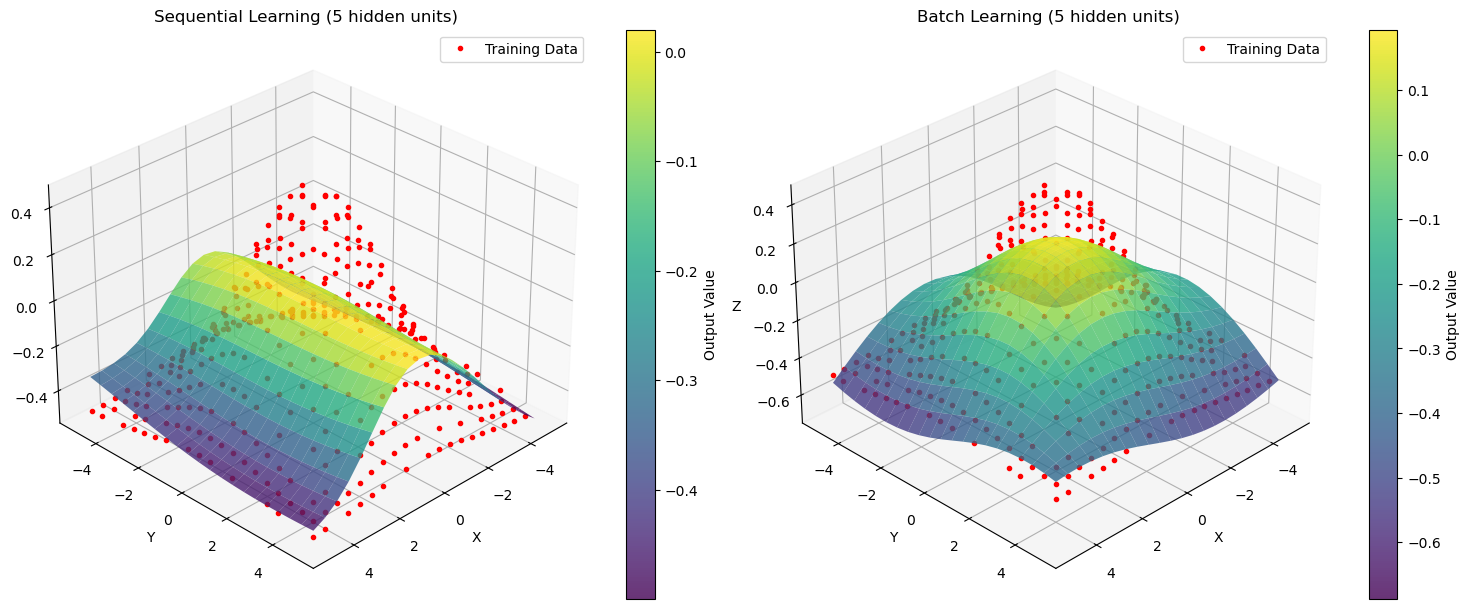

Shape of W: (10, 3)
Shape of V: (1, 11)


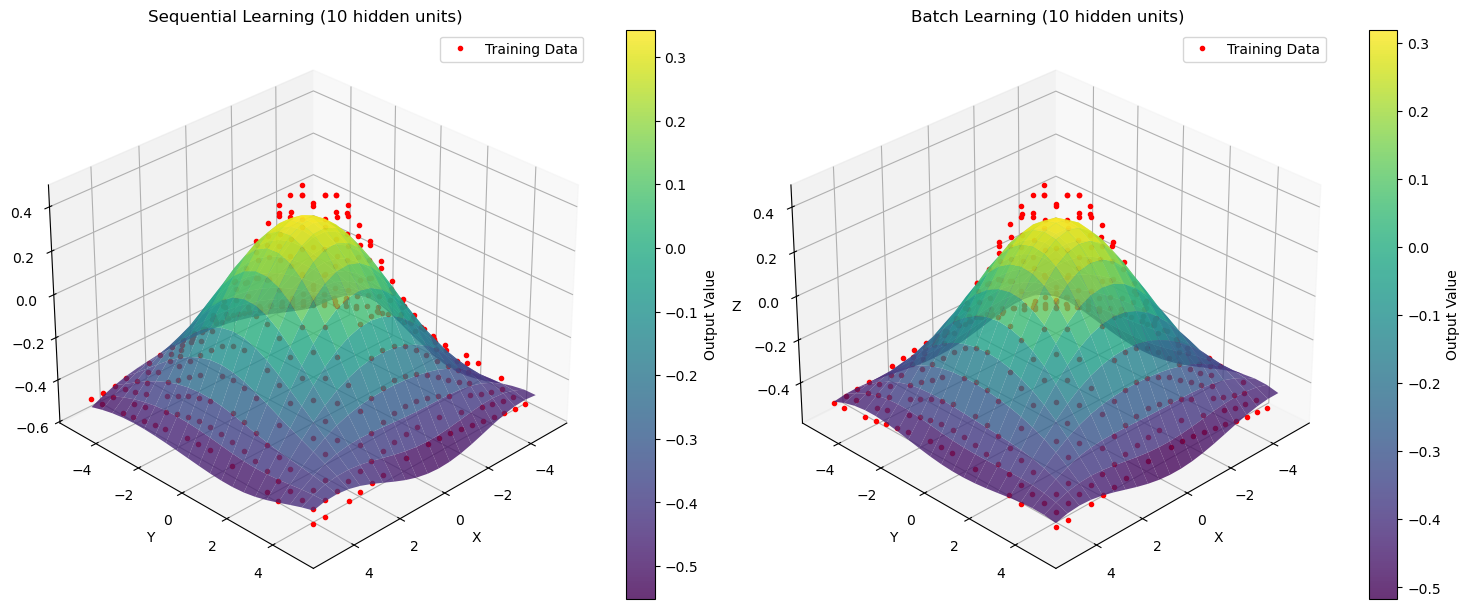

Shape of W: (20, 3)
Shape of V: (1, 21)


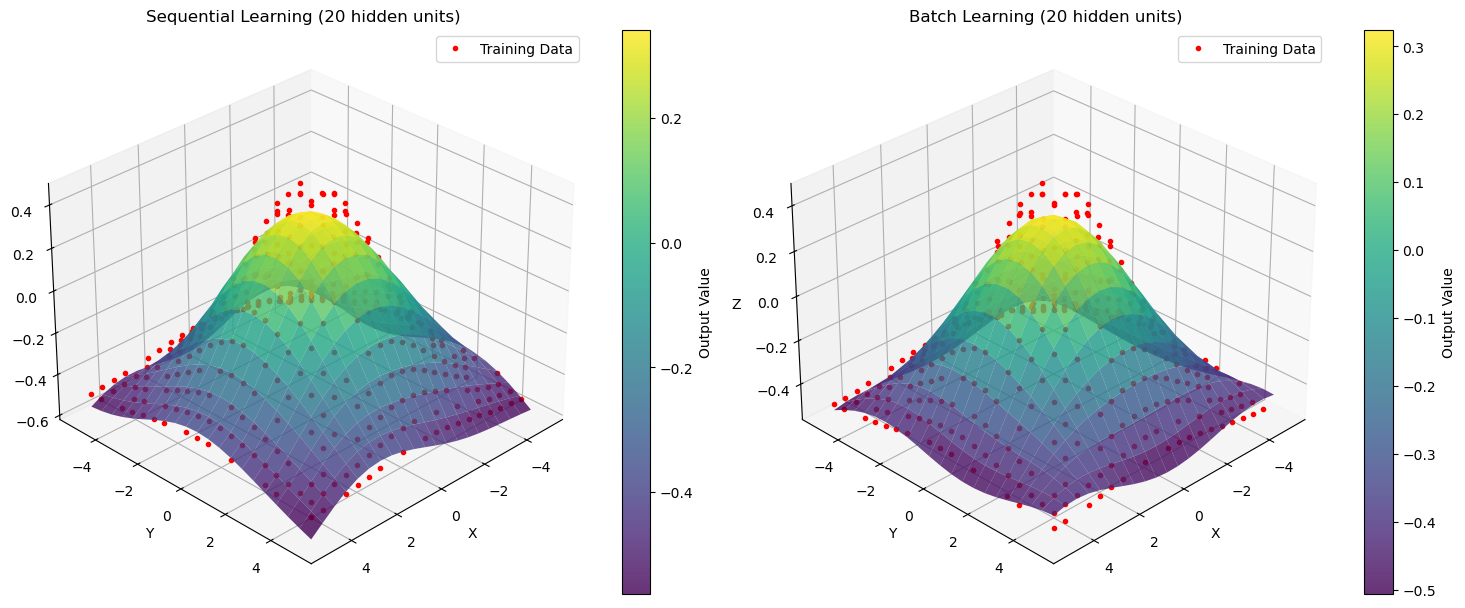

Shape of W: (50, 3)
Shape of V: (1, 51)


KeyboardInterrupt: 

In [115]:
# Train the network with different hidden layer sizes
hidden_sizes = [5, 10, 20, 50, 100]
errors_batch = []
errors_seq = []

# Enable interactive mode
plt.ion()

for size in hidden_sizes:
    # Train networks
    W_batch, error_batch = train_batch(patterns_train, targets_train, size, 
                                     epochs=3000, lr=0.005, momentum=0.9)
    W_seq, error_seq = train_sequential_func(patterns_train, targets_train, size, 
                                           epochs=3000, lr=0.005, momentum=0.9)
    
    # Get predictions for both training and validation sets
    # Batch model
    train_pred_batch = predict(patterns_train, W_batch)
    val_pred_batch = predict(patterns_val, W_batch)
    
    # Sequential model
    train_pred_seq = predict(patterns_train, W_seq)
    val_pred_seq = predict(patterns_val, W_seq)
    
    # Compute metrics
    batch_metrics = {
        'train': compute_metrics(train_pred_batch, targets_train),
        'val': compute_metrics(val_pred_batch, targets_val)
    }
    
    seq_metrics = {
        'train': compute_metrics(train_pred_seq, targets_train),
        'val': compute_metrics(val_pred_seq, targets_val)
    }
    
    # Store results
    results.append({
        'size': size,
        'batch': {
            'weights': W_batch,
            'training_error': error_batch,
            'metrics': batch_metrics
        },
        'sequential': {
            'weights': W_seq,
            'training_error': error_seq,
            'metrics': seq_metrics
        }
    })
    
    # Plot the results
    fig = plt.figure(figsize=(15, 6))
    
    # Sequential learning plot
    ax1 = fig.add_subplot(121, projection='3d')
    scatter1 = ax1.plot3D(patterns_train[0], patterns_train[1], targets_train[0], 
                         'r.', label='Training Data')
    surf1 = ax1.plot_surface(xx, yy, predict(patterns, W_seq).reshape(xx.shape), 
                            cmap='viridis', alpha=0.8)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(f'Sequential Learning ({size} hidden units)')
    ax1.view_init(elev=30, azim=45)
    fig.colorbar(surf1, ax=ax1, label='Output Value')
    ax1.legend()

    # Batch learning plot
    ax2 = fig.add_subplot(122, projection='3d')
    scatter2 = ax2.plot3D(patterns_train[0], patterns_train[1], targets_train[0], 
                         'r.', label='Training Data')
    surf2 = ax2.plot_surface(xx, yy, predict(patterns, W_batch).reshape(xx.shape), 
                            cmap='viridis', alpha=0.8)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_title(f'Batch Learning ({size} hidden units)')
    ax2.view_init(elev=30, azim=45)
    fig.colorbar(surf2, ax=ax2, label='Output Value')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Print summary table of results
print("\nResults Summary:")
print("Hidden Size | Mode       | Train MSE  | Train RMSE | Train MAE  | Val MSE    | Val RMSE   | Val MAE")
print("-" * 95)

for result in results:
    size = result['size']
    
    # Batch results
    b_train = result['batch']['metrics']['train']
    b_val = result['batch']['metrics']['val']
    print(f"{size:^10} | Batch      | {b_train['MSE']:.6f} | {b_train['RMSE']:.6f} | {b_train['MAE']:.6f} | "
          f"{b_val['MSE']:.6f} | {b_val['RMSE']:.6f} | {b_val['MAE']:.6f}")
    
    # Sequential results
    s_train = result['sequential']['metrics']['train']
    s_val = result['sequential']['metrics']['val']
    print(f"{' ':^10} | Sequential | {s_train['MSE']:.6f} | {s_train['RMSE']:.6f} | {s_train['MAE']:.6f} | "
          f"{s_val['MSE']:.6f} | {s_val['RMSE']:.6f} | {s_val['MAE']:.6f}")
    print("-" * 95)

# Plot training and validation errors
plt.figure(figsize=(12, 6))
for result in results:
    size = result['size']
    plt.plot(result['batch']['training_error'], 
             label=f'{size} Hidden Units (Batch)', alpha=0.8)
    plt.plot(result['sequential']['training_error'], '--', 
             label=f'{size} Hidden Units (Sequential)', alpha=0.8)

plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Error for Different Hidden Layer Sizes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()
